# Assignment 2: Data Preprocessing
## By: Cristian C Noriega M, Toyosi, Arshdeep Singh, Ang Dorje Sherpa


### Task:
Using Data Preprocessing technqiues on a chosen dataset to prepare it for future modeling/analysis

In [3]:
#cell for importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.cluster import hierarchy
import geopandas as gpd
import plotly.express as px
import folium
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from kneed import KneeLocator
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt


from scipy.spatial.distance import euclidean

pd.set_option('display.max_rows', 35)

In [4]:
#Bringing in the two datasets we will be using and assigning them both to their own dataframe

df = pd.read_csv('world-data-2023.csv')
continent_df = pd.read_csv('Continent List.csv')

In [5]:
# Brief overview of the main dataset that shows name and datatype of columns and number of rows. 
# There are null values in pretty much every column. We will have to spend time fixing them as null values can cause issues later on.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                            195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    object 
 10  CPI                       

In [6]:
# Shows the first five columns of the dataset, shows us what to expect for each column in terms of length, type, and scale of digits.
# We can see that there are numeric and alphabetical values. 

df.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


# DATA CLEANING
#### Rename columns, drop 2 columns, and 1 country. Drop countries where there are less than 25 Non-NA values 

In [7]:
#Renaming columns for two purposes. First, is to clean the names. Secondly, the $ shows that the values are standardized to USD and 
#the values in the rate columns are percentanges ('%')

df = df.rename(columns={'Density\n(P/Km2)':'Density(P/km2)','Total tax rate':'Total tax rate (%)',
                        'Minimum wage':'Minimum wage($)','Unemployment rate':'Unemployment rate(%)',
                        'Gasoline Price':'Gasoline Price($)','Out of pocket health expenditure':'Out of pocket health expenditure(%)'})

In [8]:
#Dropping columns that we will not need in our analysis 'Noisy data'.
#Also dropping the country (row) with its Latitude missing as we will be plotting a map later on.

df.drop(['Abbreviation','Calling Code'],axis=1,inplace=True) #columns not needed
df.drop(df[df['Latitude'].isna()].index,inplace=True)#drop country without Latitude - name was not able to be reconigzed


In [9]:
#Dropping any country/row that has less than 25 Non-NA values as this is way too little information to be useful in analysis 

df.dropna(axis=0,inplace=True,thresh=25)

In [10]:
# Re moving duplicates as they lead to Noisy Data, and will add skew to the data if there is more than one row per country.

duplicate = df[df.duplicated('Country')]
duplicate

,Country,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude


#### Fill missing data

In [11]:
# Filling in the official language for the 4 countries, data was missing so we are doing it manually here. 

df.loc[df['Country'] == 'Australia', 'Official language'] ='English'
df.loc[df['Country'] == 'United States', 'Official language'] ='English'
df.loc[df['Country'] == 'Mexico', 'Official language'] ='Spanish'
df.loc[df['Country'] == 'Japan', 'Official language'] ='Japanese'

# Filling countries where there is no data about the capital city

df.loc[df['Country'] == 'Libya', 'Capital/Major City'] ='Tripoli'
df.loc[df['Country'] == 'Singapore', 'Capital/Major City'] ='Singapore'

# Filling null values for largest city by setting it equivalent to the country's capital city. 
# In most cases, the largest city is usually the capital, so this is an automated, although not 100% foolproof method of data cleaning. 

df['Largest city'].fillna(df['Capital/Major City'],inplace=True)

In [12]:
# Checking a few of the columns one by one to identify if there are any NaN values

df[df['Land Area(Km2)'].isna()]
df[df['Latitude'].isna()]
df[df['Official language'].isna()]
df[df['Capital/Major City'].isna()]
df[df['Agricultural Land( %)'].isna()]
df[df['Co2-Emissions'].isna()]
df[df['Unemployment rate(%)'].isna()]
df[df['Gasoline Price($)'].isna()]
df[df['Armed Forces size'].isna()]

,Country,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude
38,Comoros,467,71.50%,"2,235",NaN,31.88,"Moroni, Comoros",202,103.62,-4.30%,...,74.80%,0.27,"850,886",43.30%,NaN,219.60%,4.34%,"248,152",-11.645500,43.333300
48,Dominica,96,33.30%,751,NaN,12.00,Roseau,180,103.87,1.00%,...,28.40%,1.08,"71,808",NaN,22.10%,32.60%,NaN,"50,830",15.414999,-61.370976
67,Grenada,331,23.50%,349,NaN,16.47,"St. George's, Grenada",268,107.43,0.80%,...,57.00%,1.41,"112,003",NaN,19.40%,47.80%,NaN,"40,765",12.116500,-61.679000
89,Kiribati,147,42.00%,811,NaN,27.89,South Tarawa,66,99.55,0.60%,...,0.20%,0.20,"117,606",NaN,22.00%,32.70%,NaN,"64,489",1.836898,-157.376832
107,Marshall Islands,329,63.90%,181,NaN,29.03,Majuro,143,NaN,NaN,...,10.00%,0.42,"58,791",NaN,17.80%,65.90%,NaN,"45,514",7.131474,171.184478
111,Federated States of Micronesia,784,31.40%,702,NaN,22.82,Palikir,143,112.1,0.50%,...,2.50%,0.18,"113,815",NaN,25.20%,60.50%,NaN,"25,963",7.425554,150.550812
132,Palau,39,10.90%,459,NaN,14.00,Ngerulmud,224,118.17,1.30%,...,21.80%,1.18,"18,233",NaN,21.30%,76.60%,NaN,"14,491",7.514980,134.582520
145,Saint Kitts and Nevis,205,23.10%,261,NaN,12.60,Basseterre,238,104.57,-1.00%,...,56.60%,2.52,"52,823",NaN,18.50%,49.70%,NaN,"16,269",17.357822,-62.782998
146,Saint Lucia,301,17.40%,616,NaN,12.00,Castries,414,110.13,1.90%,...,48.40%,0.64,"182,790",67.10%,18.20%,34.70%,20.71%,"34,280",13.909444,-60.978893
147,Saint Vincent and the Grenadines,284,25.60%,389,NaN,14.24,Kingstown,220,109.67,2.30%,...,21.40%,0.66,"100,455",65.90%,25.40%,37.00%,18.88%,"58,185",12.984305,-61.287228


In [13]:
# For the three columns below, we feel comfortable with the null values be set to 0. 
# Some of the countries have been researched online and the others most likely are 0 as well.

columns_to_check = ['Armed Forces size','Agricultural Land( %)','Co2-Emissions']

nan_rows = df[columns_to_check].isna().any(axis=1)

df.loc[nan_rows, columns_to_check] = 0

In [14]:
# Some attribute cleaning here as we remove characters so the columns can be converted from string/object to float numbers 

df = df.replace({',': ''}, regex=True)
df = df.replace({'$': ''}, regex=True)
df = df.replace({'%': ''}, regex=True)
df = df.replace({'[$,%]': ''}, regex=True)

df.fillna(0,inplace=True)

In [15]:
numeric_col = ['Density(P/km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Co2-Emissions', 'CPI', 'CPI Change (%)','Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality','Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)','Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population']
df[numeric_col] = df[numeric_col].astype(float)

In [14]:
#Observing the summary statistics of our dataset. The range of the columns is wide so scaling might be needed to place every attribute on an equal playing field. 

df.describe()

,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude
count,185.000000,185.000000,1.850000e+02,1.850000e+02,185.000000,1.850000e+02,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,1.850000e+02,185.000000,185.000000,185.000000,185.000000,1.850000e+02,185.000000,185.000000
mean,209.016216,36.402703,7.229319e+05,1.462162e+05,20.357243,1.806545e+05,182.253838,6.461622,2.703892,31.636216,...,32.616216,1.810973,4.127905e+07,59.373514,14.907027,40.064324,6.479081,2.290587e+07,18.860657,18.708900
std,661.664169,23.825467,1.961925e+06,3.684423e+05,9.886298,8.452968e+05,392.233072,24.082604,1.279453,24.018940,...,19.406192,1.656919,1.483355e+08,17.530480,8.217148,21.250553,5.169003,7.635809e+07,23.833346,66.401185
min,2.000000,0.000000,6.100000e+01,0.000000e+00,6.400000,0.000000e+00,0.000000,-4.300000,0.980000,0.000000,...,0.000000,0.000000,1.823300e+04,0.000000,0.000000,0.000000,0.000000,1.449100e+04,-40.900557,-175.198242
25%,32.000000,17.400000,2.889600e+04,7.000000e+03,11.500000,2.739000e+03,112.330000,0.800000,1.710000,10.900000,...,17.600000,0.310000,2.657637e+06,54.700000,10.200000,30.100000,3.040000,1.453958e+06,4.570868,-9.429499
50%,83.000000,38.400000,1.471810e+05,2.500000e+04,18.070000,1.296300e+04,123.780000,2.200000,2.250000,31.700000,...,30.500000,1.410000,9.746117e+06,62.000000,14.900000,37.100000,4.930000,4.717305e+06,17.060816,20.939444
75%,203.000000,54.700000,5.817300e+05,1.260000e+05,28.750000,6.516600e+04,155.860000,3.900000,3.590000,48.100000,...,44.200000,2.890000,3.036604e+07,68.800000,20.700000,47.800000,9.020000,1.592473e+07,39.074208,48.516388
max,8358.000000,82.600000,1.709824e+07,3.031000e+06,46.080000,9.893038e+06,4583.710000,254.900000,6.910000,98.300000,...,81.600000,8.420000,1.397715e+09,86.800000,37.200000,219.600000,28.180000,8.429340e+08,64.963051,178.065032


In [15]:
# Check for the number of NaN values by column

nan_counts = df.isna().sum()

print(nan_counts)

Country                                      0
Density(P/km2)                               0
Agricultural Land( %)                        0
Land Area(Km2)                               0
Armed Forces size                            0
Birth Rate                                   0
Capital/Major City                           0
Co2-Emissions                                0
CPI                                          0
CPI Change (%)                               0
Currency-Code                                0
Fertility Rate                               0
Forested Area (%)                            0
Gasoline Price($)                            0
GDP                                          0
Gross primary education enrollment (%)       0
Gross tertiary education enrollment (%)      0
Infant mortality                             0
Largest city                                 0
Life expectancy                              0
Maternal mortality ratio                     0
Minimum wage(

In [16]:
# Merge the DataFrames on 'Country' to add the 'Continent' column. 
#This will bring in a new column that contains additional context and hierarchy in terms of geography

df = df.merge(continent_df, on='Country', how='left')
df[df['Continent'].isna()]

,Country,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude,Continent
10,The Bahamas,39.0,1.4,13880.0,1000.0,13.97,Nassau Bahamas,1786.0,116.22,2.5,...,1.94,389482.0,74.6,14.8,33.8,10.36,323784.0,25.034280,-77.396280,NaN
78,Republic of Ireland,72.0,64.5,70273.0,9000.0,12.50,Dublin,37711.0,106.58,0.9,...,3.31,5007069.0,62.1,18.3,26.1,4.93,3133123.0,53.412910,-8.243890,NaN
121,North Korea,214.0,21.8,120538.0,1469000.0,13.89,Pyongyang,28284.0,0.00,0.0,...,3.67,25666161.0,80.4,0.0,0.0,2.74,15947412.0,40.339852,127.510093,NaN
135,Russia,9.0,13.3,17098240.0,1454000.0,11.50,Moscow,1732027.0,180.75,4.5,...,4.01,144373535.0,61.8,11.4,46.2,4.59,107683889.0,61.524010,105.318756,NaN
175,United Kingdom,281.0,71.7,243610.0,148000.0,11.00,London,379025.0,119.62,1.7,...,2.81,66834405.0,62.8,25.5,30.6,3.85,55908316.0,55.378051,-3.435973,NaN


In [17]:
# As shown above, there are some countries with a missing continent. To fill in the missing data, we will do it manually.

countries_to_update = ['The Bahamas','Republic of Ireland', 'North Korea', 'Russia','United Kingdom']

new_continents = ['North America', 'Europe', 'Asia','Europe','Europe']

for country, new_continent in zip(countries_to_update, new_continents):
    df.loc[df['Country'] == country, 'Continent'] = new_continent

In [18]:
# We perform some categorical variable encoding by creating dummy varaibles. 
#As birth rate can changed based on continent, we transform that column into additional columns that have a Boolean data type. 
#This column describes which continent the country is in.
dummies = pd.get_dummies(df['Continent'], prefix='Continent')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummies], axis=1)

# df

In [19]:
#Checking the number of NaN values before we start creating vizzes. 

nan_counts = df.isna().sum()

print(nan_counts)

Country                    0
Density(P/km2)             0
Agricultural Land( %)      0
Land Area(Km2)             0
Armed Forces size          0
                          ..
Continent_Asia             0
Continent_Europe           0
Continent_North America    0
Continent_Oceania          0
Continent_South America    0
Length: 40, dtype: int64


# VISUALIZATIONS

<Axes: xlabel='Birth Rate', ylabel='Count'>

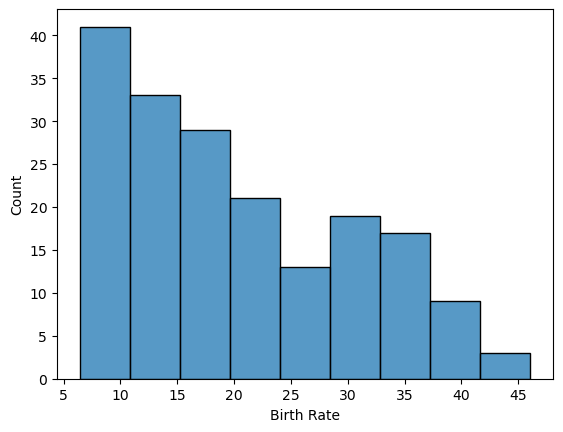

In [20]:
#A look at the histogram for Birth Rate, the dependent variable we will be looking at. We can see shape (right skewed), and there does not appear to be any outliers.
#Most of the birth rates seem to be on the lower side, mostly betweeen the 6-25 range.

sns.histplot(data=df, x="Birth Rate")

In [21]:
#We will create a correlation matrix to see how attributes correlate to each other. It will show, in a visual way, how columns relate. 

# Select only float columns
float_columns = df.select_dtypes(include=['float64'])

# Create a correlation matrix for the float columns
correlation_matrix = float_columns.corr()

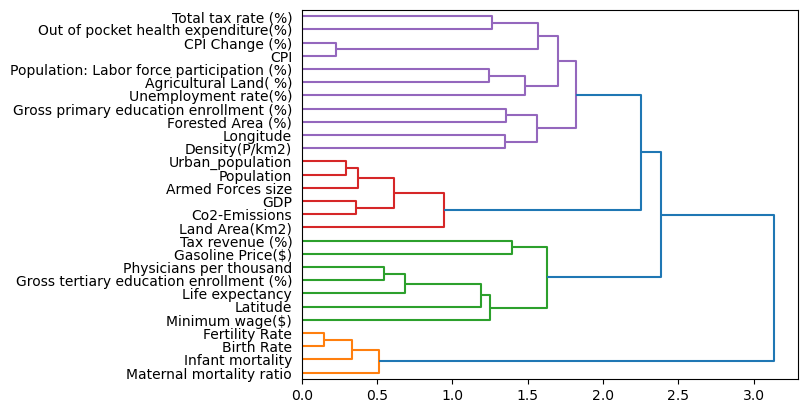

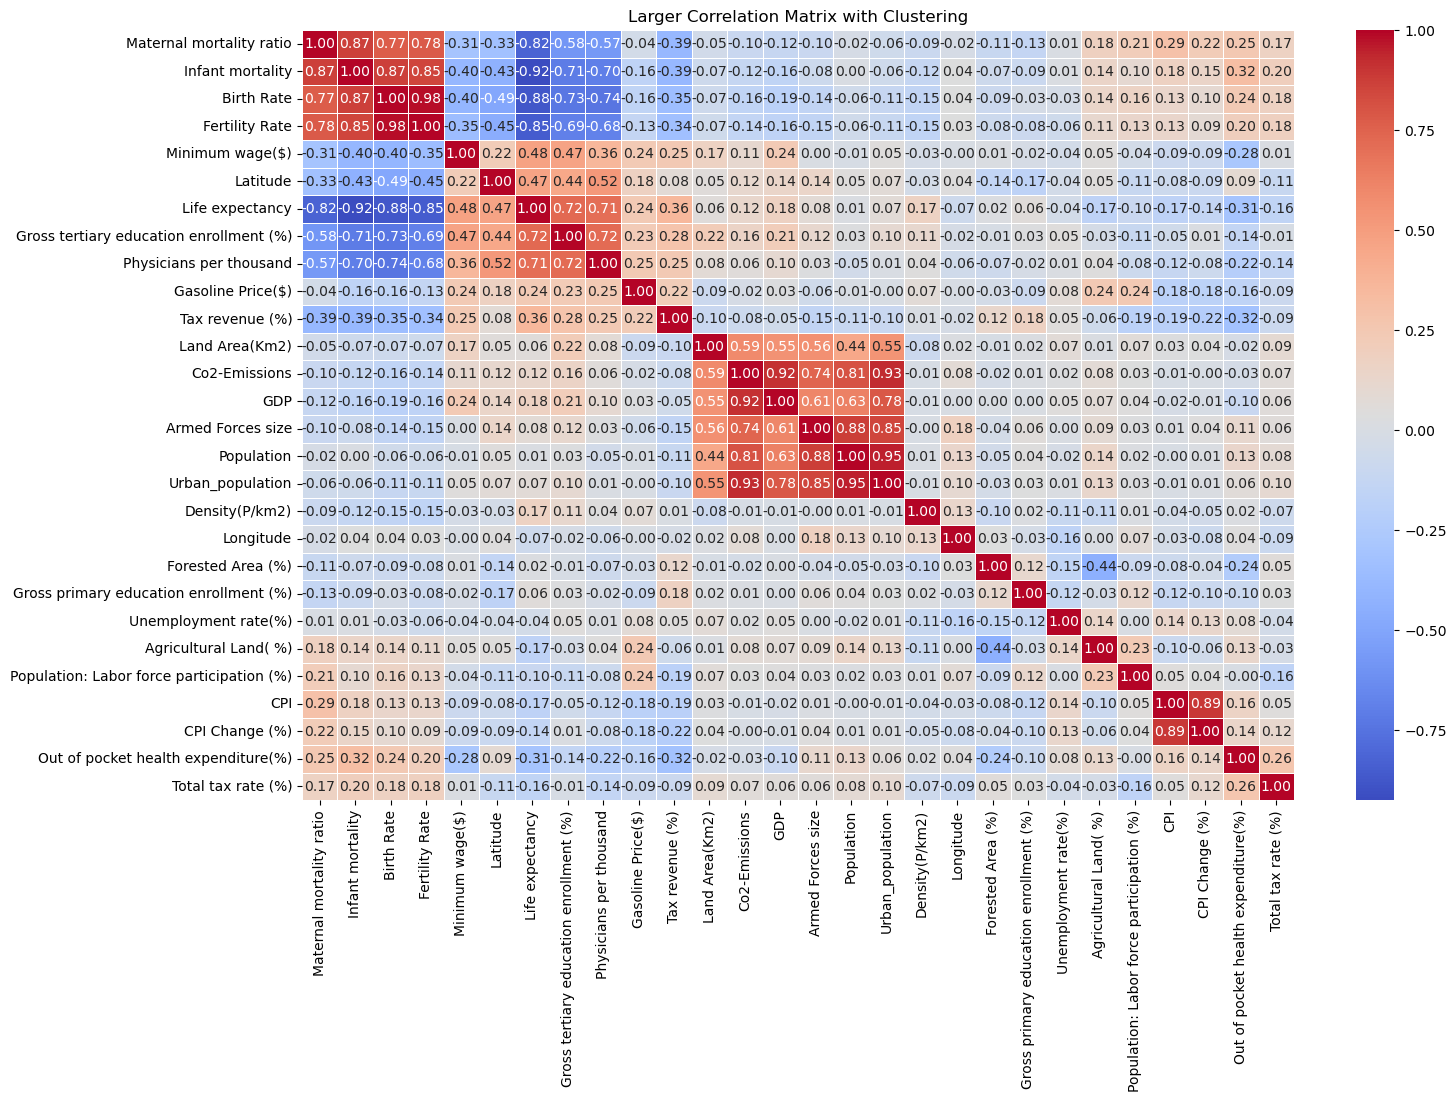

In [22]:
# We perform hierarchical clustering on the corr matrix to create a dendogram which visualizes the columns that are most alike. 
# In future assignments, we should pay attention to multi-collineearity when constructing models. Feertility Rate and Birth Rate seem to be highly correlated, which is logical.
# Fertility Rate might be a candidate to drop as it is highly correlated with the dependent in this case. 
# Life expectancy and the number of physicians seem to be highly negatively correlated, with some moderate negative correlations as well. 

linkage = hierarchy.linkage(correlation_matrix, method='average')
dendrogram = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, orientation='right')

# Reorder the columns based on clustering
ordered_columns = [correlation_matrix.columns[i] for i in dendrogram['leaves']]
ordered_corr_matrix = correlation_matrix.reindex(ordered_columns)[ordered_columns]

# Create a heatmap with reordered columns
plt.figure(figsize=(16, 10))  # Specify the figsize parameter to make the heatmap larger
sns.heatmap(ordered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


plt.title('Larger Correlation Matrix with Clustering')

plt.show()

### Scatterplot by birth rate and unemployment rate(%)

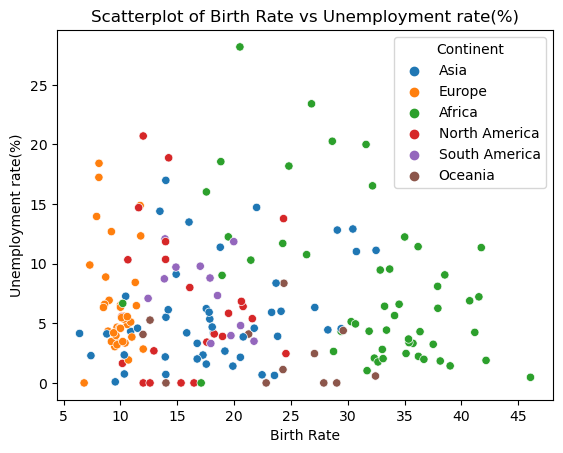

In [23]:
# Using the continent information that we brought in from earlier, we can see that there are fairly clear clusters of Birth Rate by Continent.
# However, UE Rate does not seem to have a clear indicator on Birth Rate, telling us the job market may not have a huge influence. 

sns.scatterplot(data=df, x='Birth Rate', y='Unemployment rate(%)',hue='Continent')


plt.xlabel('Birth Rate')
plt.ylabel('Unemployment rate(%)')
plt.title('Scatterplot of Birth Rate vs Unemployment rate(%)')


plt.show()

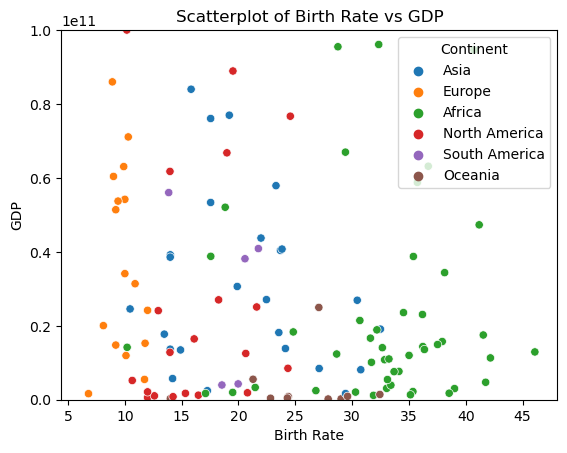

In [24]:
# We create a scatterplot and lower the y-limit to $100B so we can clearly see more datapoints. Seems to be no real correlation here either. 
# Economic factors so far have shown not much indication on Birth Rate.

sns.scatterplot(data=df, x='Birth Rate', y='GDP',hue='Continent')


plt.xlabel('Birth Rate')
plt.ylabel('GDP')
plt.title('Scatterplot of Birth Rate vs GDP')
plt.ylim(0, 100000000000)

plt.show()

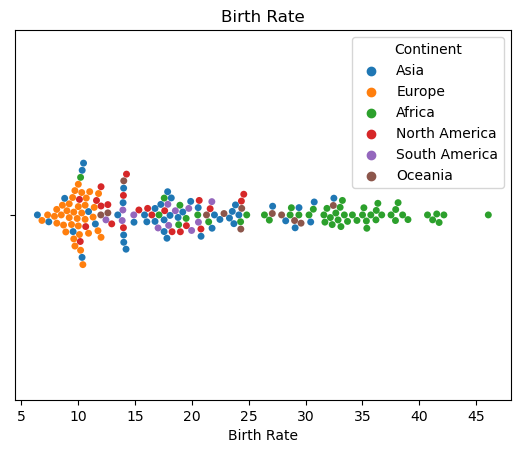

In [25]:
# We have seen above that Birth Rate and Continent have some sort of relationship. 
# The swarm plot shows each data point and upholds our thinking. Especially in the continents of Africa and Europe.


sns.swarmplot(data=df, x="Birth Rate",hue='Continent')

plt.title('Birth Rate')


plt.show()

<Axes: xlabel='Unemployment rate(%)'>

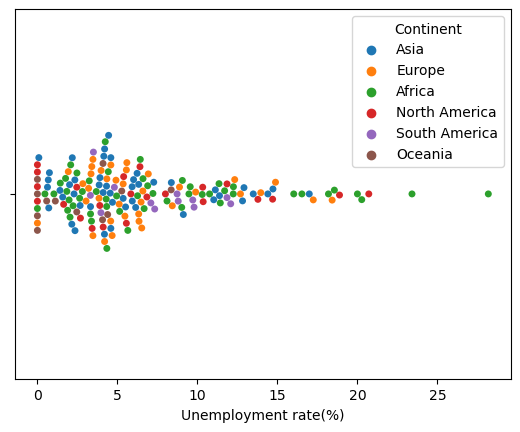

In [26]:
sns.swarmplot(data=df, x="Unemployment rate(%)",hue='Continent')

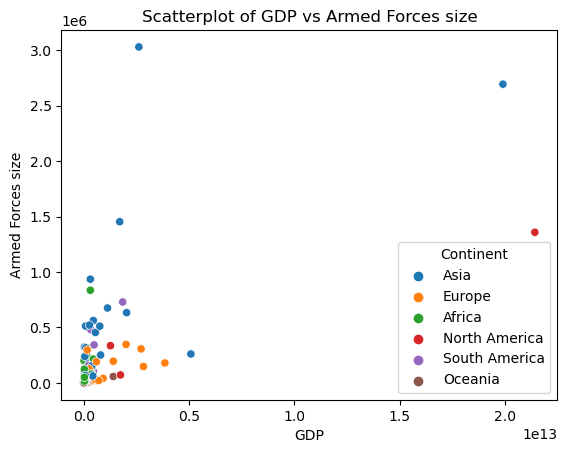

In [27]:
# Create a scatterplot
sns.scatterplot(data=df, x='GDP', y='Armed Forces size',hue='Continent')


plt.xlabel('GDP')
plt.ylabel('Armed Forces size')
plt.title('Scatterplot of GDP vs Armed Forces size')


plt.show()

# Create a map

In [28]:
# Here we have created a map to show the Birth Rates, colored in by certain thresholds. It gives a global view on the values. 
# The Southern Hemisphere seems to have the higher birth rates than the North. While the Eastern Hemisphere has higher values than the West.

m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate over rows in the DataFrame and add markers
for _, row in df.iterrows():
    country_name = row['Country']
    birth_rate = row['Birth Rate']
    latitude = row['Latitude']
    longitude = row['Longitude']

    # Customize marker color based on Birth Rate
    if birth_rate < 10:
        marker_color = 'green'
    elif 10 <= birth_rate < 15:
        marker_color = 'orange'
    else:
        marker_color = 'red'

    # Create markers for each country
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=6,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        popup=f"{country_name}<br>Birth Rate: {birth_rate}",
    ).add_to(m)


In [40]:
m

## Visualizations by languages and continents

In [30]:
most_spoken_languages = df['Official language'].value_counts()
top_10_languages = most_spoken_languages.head(10)
top_10_languages.reset_index()

,Official language,count
0,English,31
1,French,24
2,Spanish,20
3,Arabic,17
4,Portuguese,7
5,Swahili,4
6,Russian,4
7,German,3
8,Italian,2
9,Persian,2


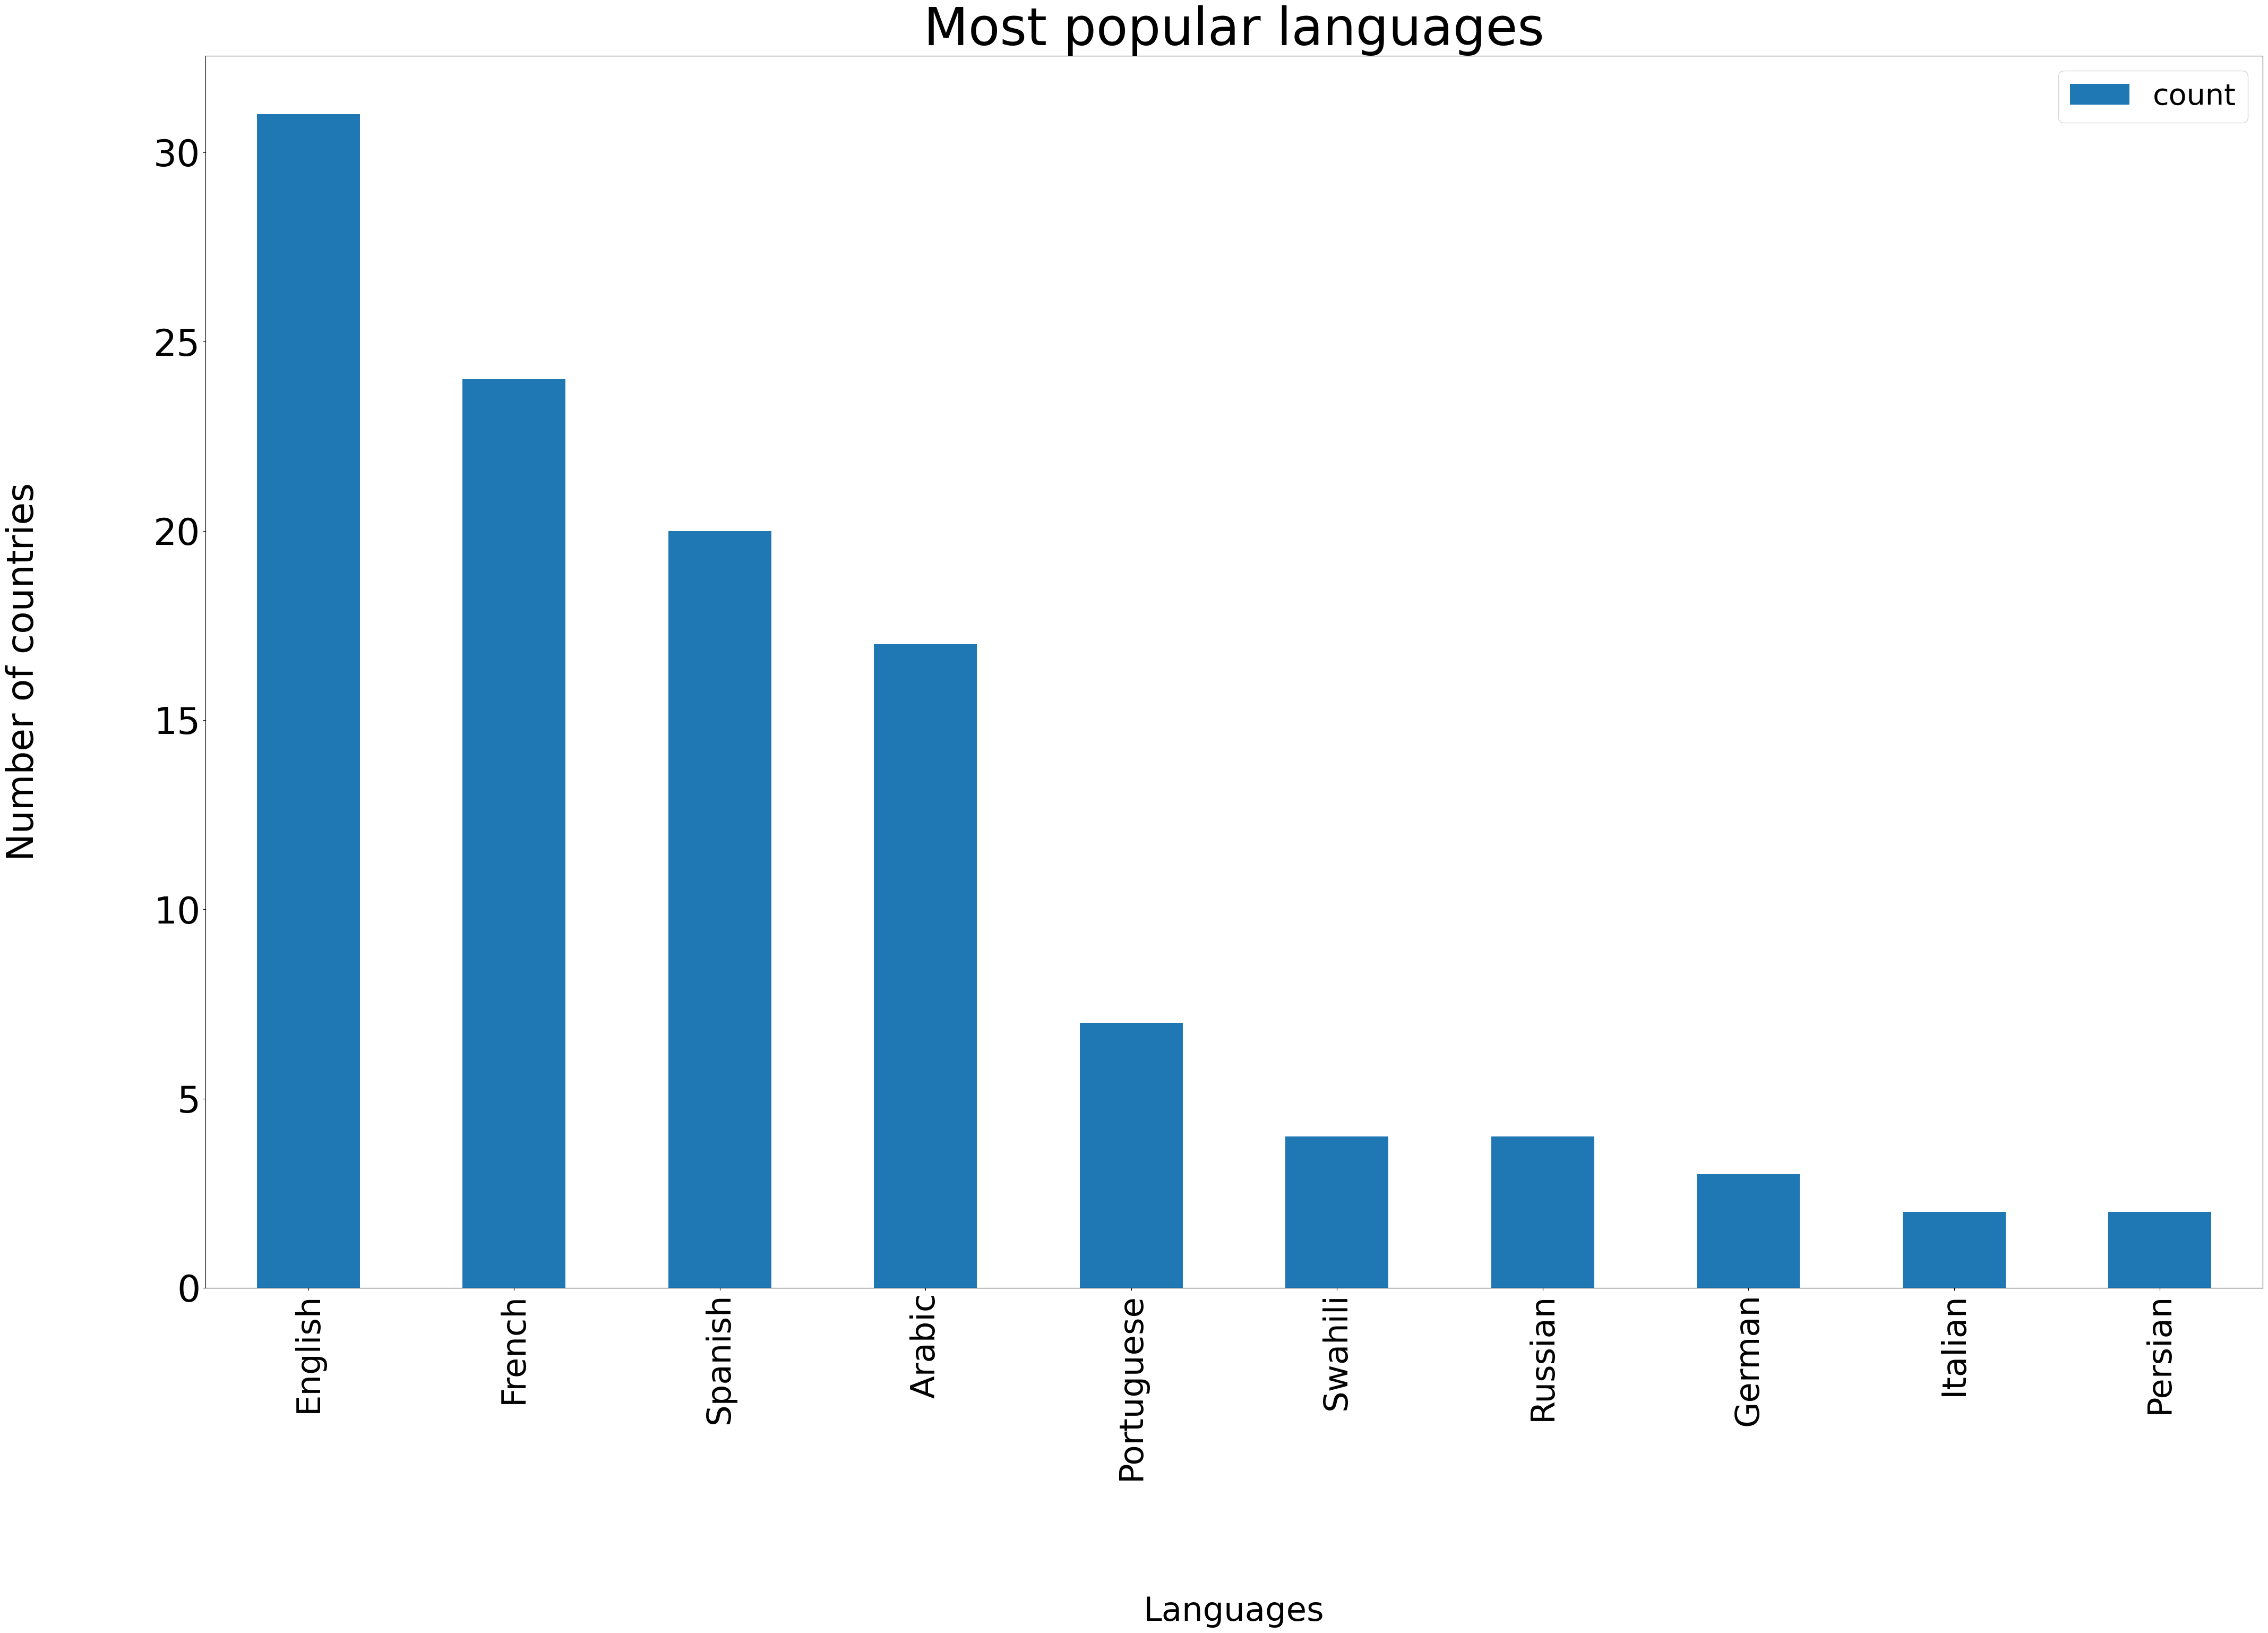

In [31]:
fig,ax = plt.subplots(figsize=(50,40))
top_10_languages.plot(kind='bar',ax=ax)

ax.yaxis.set_major_formatter('{x:,.0f}')

plt.ylabel('Number of countries',fontsize=50)
plt.xlabel('Languages',fontsize=45)

ax.yaxis.set_label_coords(-0.08,0.5)
ax.xaxis.set_label_coords(0.5,-0.25)

ax.legend(fontsize=40)

plt.xticks(fontsize=45)
plt.yticks(fontsize=50)

plt.subplots_adjust(bottom=0.3)

ax.set_title("Most popular languages", fontsize=70)



plt.show()

In [32]:
def get_top3(df, language):
    def top(df):
        return df.sort_values(by='Population', ascending=False)[:10]
    
    return df[df['Official language'] == language].groupby('Official language').apply(top).reset_index(drop=True)


top_english_countries = get_top3(df, 'English')
# top_spanish_countries = get_top3(your_dataframe, 'Spanish')
# top_french_countries = get_top3(your_dataframe, 'French')

In [33]:
vis = top_english_countries.pivot_table('Population',index='Country',columns='Continent',aggfunc=sum).T
vis.fillna(0,inplace=True)


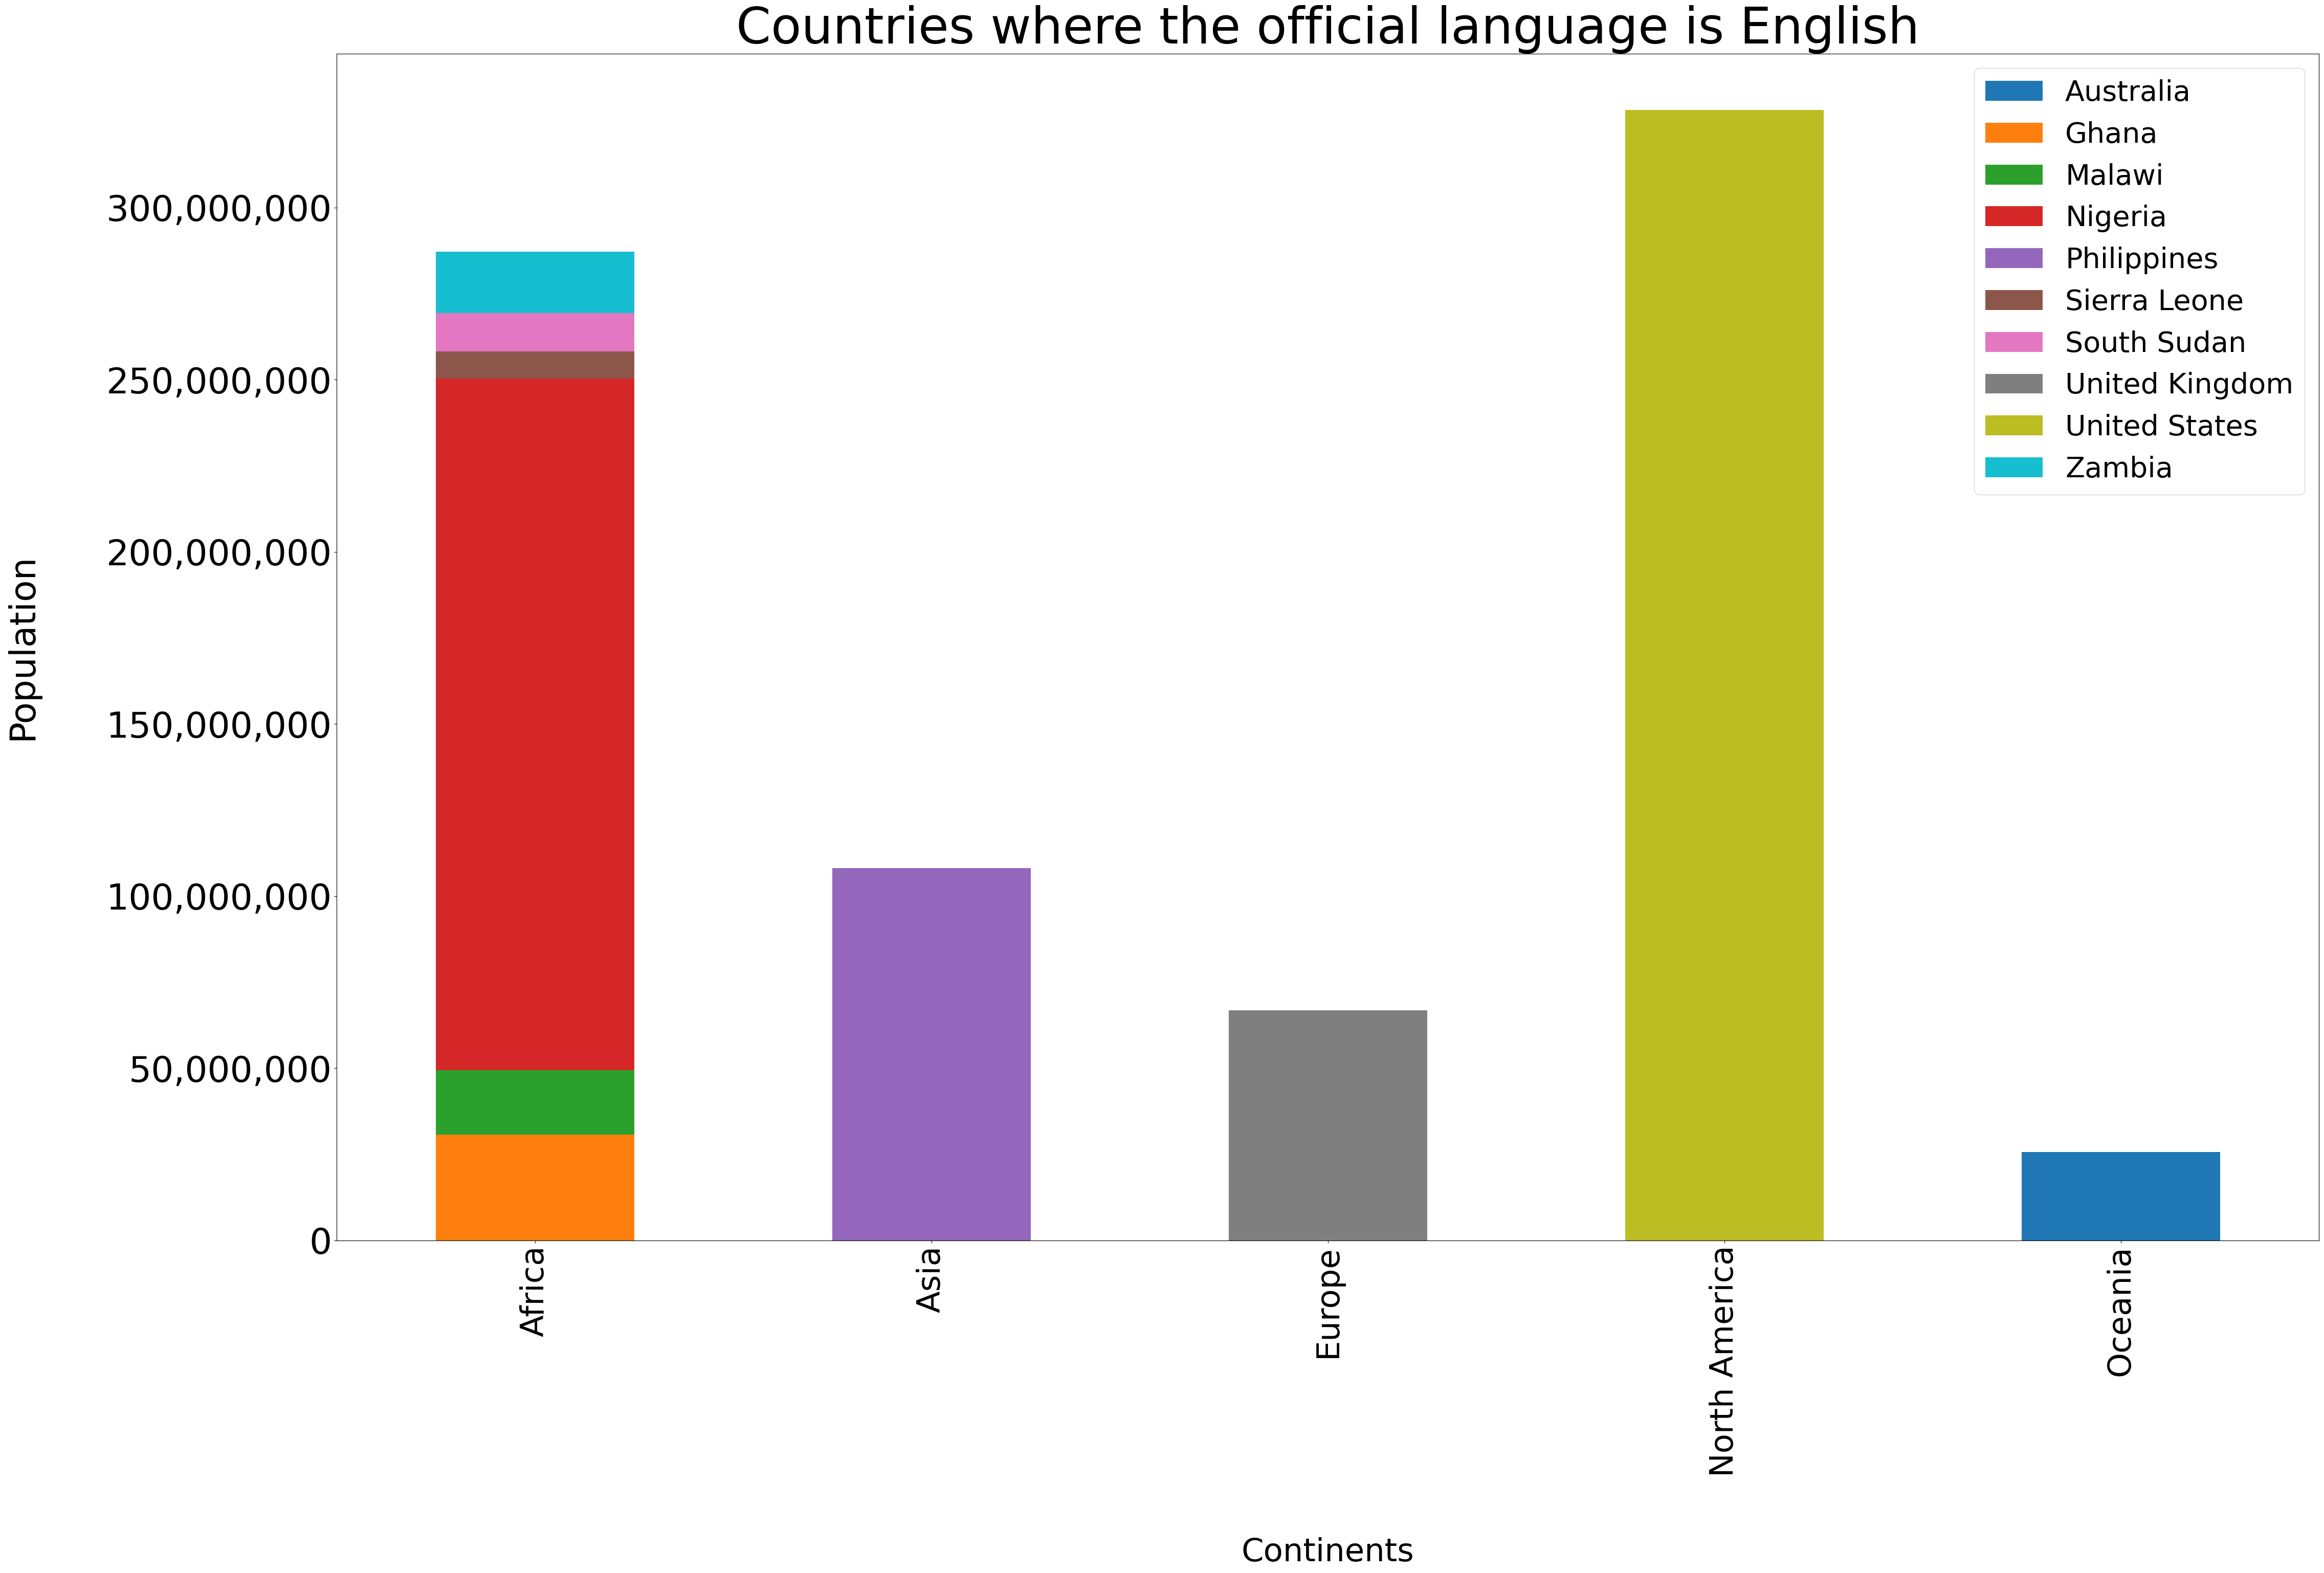

In [34]:
fig,ax = plt.subplots(figsize=(50,40))
vis.plot(kind='bar',stacked=True,ax=ax)

ax.yaxis.set_major_formatter('{x:,.0f}')

plt.ylabel('Population',fontsize=50)
plt.xlabel('Continents',fontsize=45)

ax.yaxis.set_label_coords(-0.15,0.5)
ax.xaxis.set_label_coords(0.5,-0.25)

ax.legend(fontsize=40)

plt.xticks(fontsize=45)
plt.yticks(fontsize=50)

plt.subplots_adjust(bottom=0.3)

ax.set_title("Countries where the official language is English", fontsize=70)



plt.show()

------ Descriptive Data Mining (Arsh) ---------

In [19]:
# Assuming your DataFrame is named 'df'
df['Urban Population %'] = (df['Urban_population'] / df['Population']) * 100

df = df.drop(147, axis=0)
df = df.drop(37, axis=0)

In [20]:
scaler = StandardScaler()

numeric_col = df.select_dtypes(include=['number'])

In [21]:
# As we alluded to before, the ranges of the columns are all over the place. We create an instance of MinMaxScaler to bring in the ranges in between 0 and 1.
# This will help us in our modelling as something like Armed Forces size, which has values in the millions sometimes, will not have a skewed weight compared to something like Agricultural Land percentage. 
# We have done this after the visualizations, as the raw numbers there were more useful than what the scaled numbers would be. 
scaled_data = scaler.fit_transform(numeric_col)

# Replace the original numeric columns in the dataframe with the scaled data

df[numeric_col.columns] = scaled_data



In [22]:
selected_features = df[[
                        'Fertility Rate', 
                        'Life expectancy',
                        'Infant mortality',
                        'GDP',
                        'Gross primary education enrollment (%)', 
                        'Gross tertiary education enrollment (%)',
                        'Urban Population %',
                        'Unemployment rate(%)',
                        'CPI', 
                        'Minimum wage($)', 
                        'Physicians per thousand',  
                        'Population: Labor force participation (%)']]

In [23]:
def optimize_k_means(data, max_k, random_state):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init= 10)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

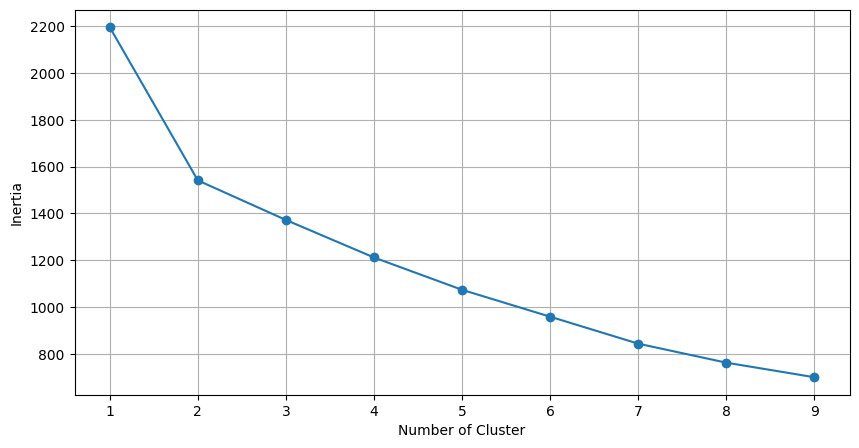

In [24]:
optimize_k_means(selected_features,10,42)

In [25]:
best_silhouette_score = -1
best_kmeans_model = None
best_random_state = None

for random_state in range(1, 102):
    kmeans = KMeans(n_clusters=3, random_state=random_state, n_init= 10)
    clusters = kmeans.fit_predict(selected_features)
    silhouette = silhouette_score(selected_features, clusters)
    
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_kmeans_model = kmeans
        best_random_state = random_state

print(f"Best Silhouette Score: {best_silhouette_score:.4f} (Random State: {best_random_state})")

Best Silhouette Score: 0.2715 (Random State: 13)


In [26]:

silhouette_coefficients = []

for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=1, n_init = 10)
    kmeans.fit(selected_features)
    score = silhouette_score(selected_features, kmeans.labels_)
    silhouette_coefficients.append(score)

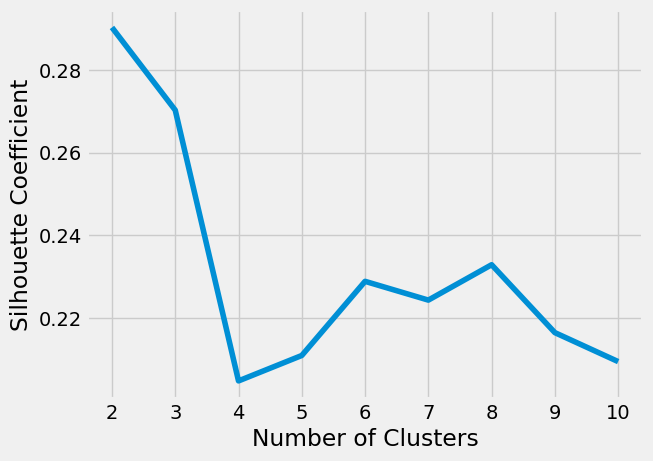

In [27]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [28]:
pca = PCA()
principal_components = pca.fit_transform(selected_features)

explained_variance = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance)

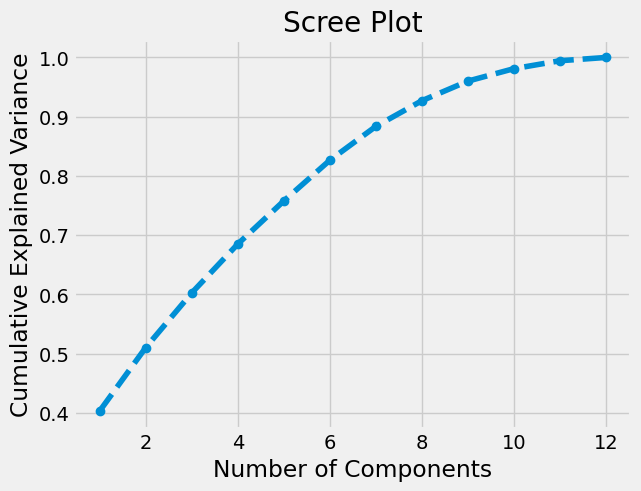

In [29]:
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [30]:
threshold = 0.95  
n_components = np.argmax(cumulative_explained_variance >= threshold) + 1

n_components

9

In [31]:
pca = PCA(n_components = 0.95)
principal_components = pca.fit_transform(selected_features)

explained_variance = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance)

In [32]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    principal_components,
    labels=labels,
    dimensions=range(5),
    color=df["Birth Rate"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

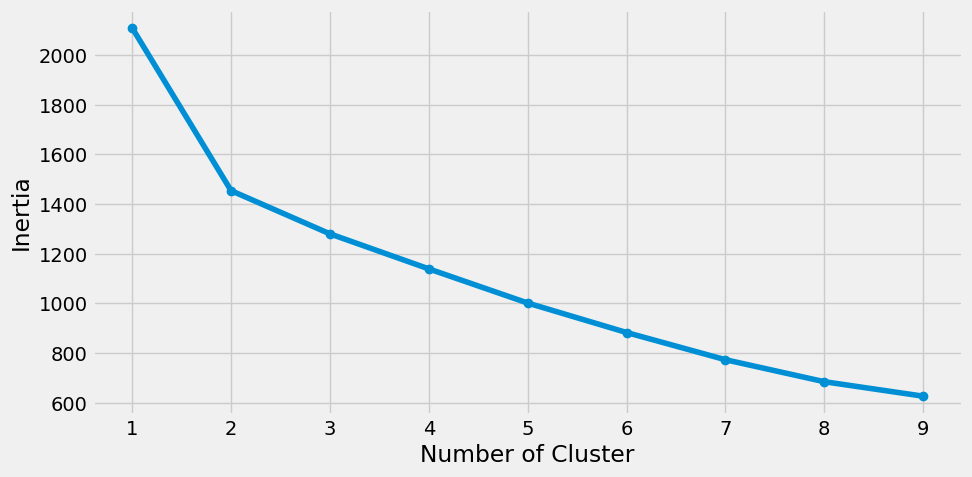

In [33]:
optimize_k_means(principal_components,10,23)

In [34]:
best_silhouette_score = -1
best_kmeans_model = None
best_random_state = None

for random_state in range(1, 102):
    kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(principal_components)
    silhouette = silhouette_score(principal_components, clusters)
    
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_kmeans_model = kmeans
        best_random_state = random_state

print(f"Best Silhouette Score: {best_silhouette_score:.4f} (Random State: {best_random_state})")

Best Silhouette Score: 0.2880 (Random State: 1)


In [35]:
kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
cluster_labels = kmeans.fit_predict(principal_components)

# Add the cluster labels to 'df'
df['Cluster_Labels'] = cluster_labels

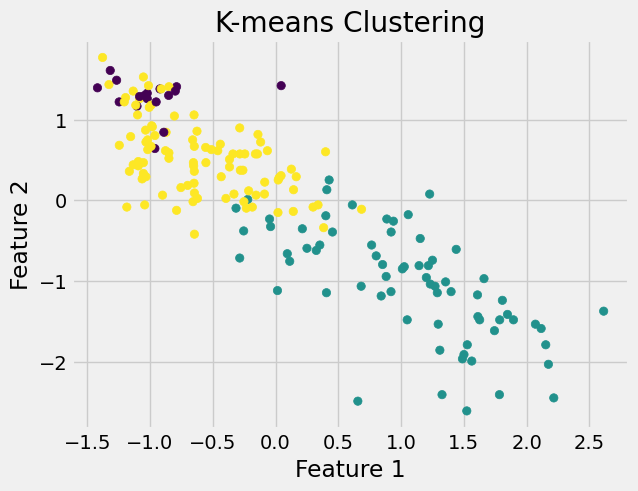

In [36]:

plt.scatter(df['Birth Rate'], df['Life expectancy'], c=df['Cluster_Labels'], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.show()

In [37]:
from collections import Counter
# Count the number of data points in each cluster
cluster_counts = Counter(cluster_labels)


for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} data points")

Cluster 1: 70 data points
Cluster 2: 96 data points
Cluster 0: 17 data points


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/x0/t0nrv2l177g5vngp2fy7vkvm0000gn/T/ipykernel_2459/1488660273.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/x0/t0nrv2l177g5vngp2fy7vkvm0000gn/T/ipykernel_2459/1488660273.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be r

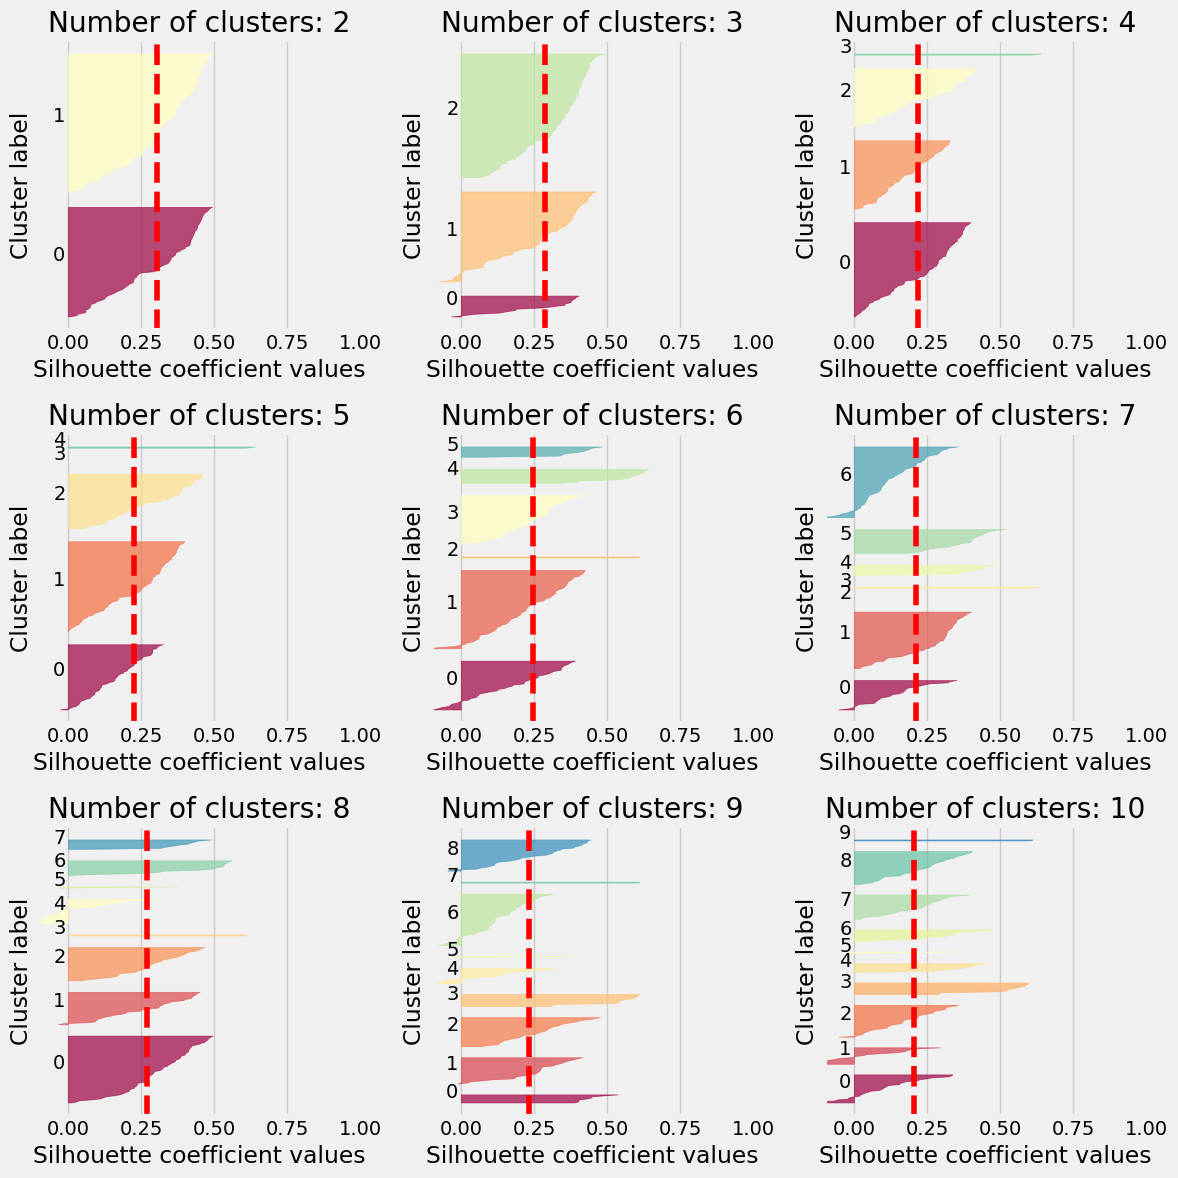

In [38]:

range_n_clusters = range(2, 11)  # Specify the range of cluster 

# Create a subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for n_clusters, ax in zip(range_n_clusters, axs.flatten()):
    
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=1).fit_predict(principal_components)
    
    # Compute silhouette scores
    silhouette_vals = silhouette_samples(principal_components, cluster_labels)
    
    # Set the vertical space between silhouette plots
    y_lower = 10
    for i, cluster_label in enumerate(np.unique(cluster_labels)):
        # Extract silhouette values for the current cluster
        cluster_silhouette_vals = silhouette_vals[cluster_labels == cluster_label]
        cluster_silhouette_vals.sort()
        
        # Calculate the number of samples in the current cluster
        cluster_size = cluster_silhouette_vals.shape[0]
        
        # Calculate the upper limit for current cluster silhouette plot
        y_upper = y_lower + cluster_size
        
        # Fill silhouette plot
        color = plt.cm.get_cmap("Spectral")(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        
        # Add cluster label at the middle of the silhouette plot
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster_label))
        
        # Update the vertical space between silhouette plots
        y_lower = y_upper + 10
    
    # Overall plot properties
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"Number of clusters: {n_clusters}")
    
    # Vertical line indicating the average silhouette score
    average_silhouette = np.mean(silhouette_vals)
    ax.axvline(x=average_silhouette, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])

# Adjust spacing between subplots
plt.tight_layout()


plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Fra

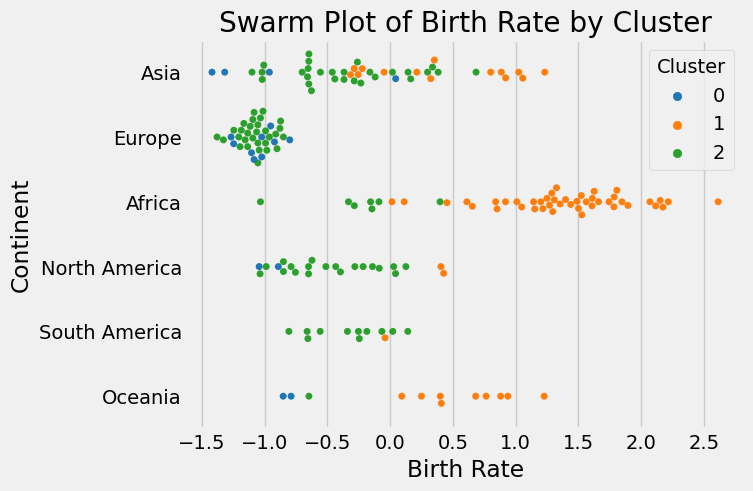

In [39]:
# Swarm plot
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]


sns.swarmplot(x='Birth Rate', y='Continent', hue='Cluster_Labels', data=df,palette=custom_palette)


plt.xlabel('Birth Rate')
plt.title('Swarm Plot of Birth Rate by Cluster')


plt.legend(title='Cluster')  # Add a legend 
plt.show()

In [40]:
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(principal_components) 

DBSCAN(eps=1)

In [41]:
cluster_labels = dbscan.labels_
# Count the number of points in each cluster, including noise points (-1)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

cluster_counts = dict(zip(unique_labels, counts))

for label, count in cluster_counts.items():
    if label == -1:
        print(f"Noise Points: {count}")
    else:
        print(f"Cluster {label}: {count} points")

score = silhouette_score(principal_components, cluster_labels)
score

Noise Points: 159
Cluster 0: 5 points
Cluster 1: 8 points
Cluster 2: 5 points
Cluster 3: 6 points


-0.3079578135357285

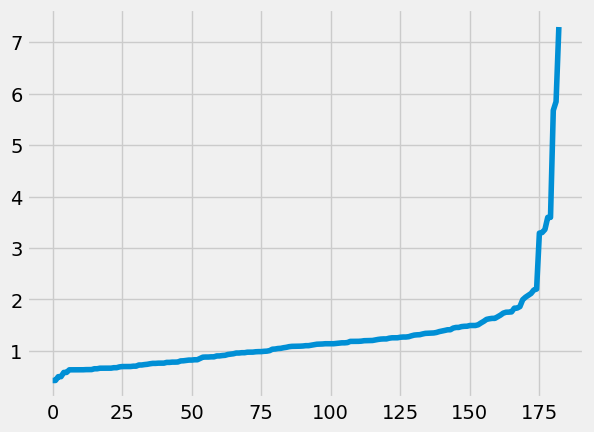

In [42]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(principal_components)
distances, indices = neighbors_fit.kneighbors(principal_components)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

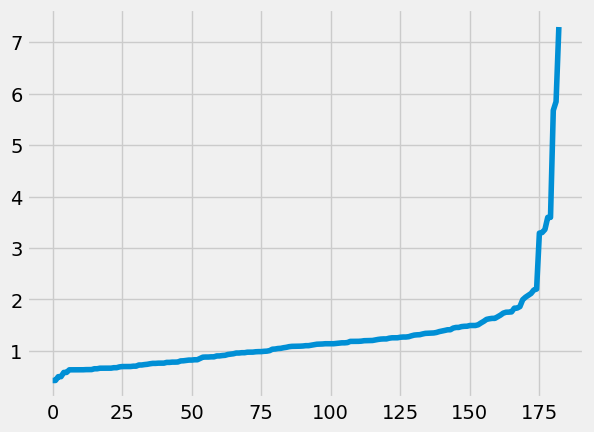

In [43]:
nn_model = NearestNeighbors(n_neighbors=2)
nn_model.fit(principal_components)
distances, indices = nn_model.kneighbors(principal_components)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [44]:
dbscan = DBSCAN(eps=2.8, min_samples=5)
dbscan.fit(principal_components)  

cluster_labels = dbscan.labels_
# Count the number of points in each cluster, including noise points (-1)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

cluster_counts = dict(zip(unique_labels, counts))

for label, count in cluster_counts.items():
    if label == -1:
        print(f"Noise Points: {count}")
    else:
        print(f"Cluster {label}: {count} points")

score = silhouette_score(principal_components, cluster_labels)
score

Noise Points: 8
Cluster 0: 166 points
Cluster 1: 9 points


0.23632685226218708

In [20]:
# df['Density(P/km2)'] = df['Density(P/km2)'].astype(float)

In [23]:

# df['Density(P/km2)'] = pd.to_numeric(df['Density(P/km2)'], errors='coerce')

In [24]:
# df['Density(P/km2)'].unique()

array([6.000e+01, 1.050e+02, 1.800e+01, 2.600e+01, 2.230e+02, 1.700e+01,
       1.040e+02, 3.000e+00, 1.090e+02, 1.230e+02, 3.900e+01, 2.239e+03,
       1.265e+03, 6.680e+02, 4.700e+01, 3.830e+02, 1.080e+02, 2.000e+01,
       1.100e+01, 6.400e+01, 4.000e+00, 2.500e+01, 8.300e+01, 7.600e+01,
       4.630e+02, 1.380e+02, 9.500e+01, 5.600e+01, 8.000e+00, 1.300e+01,
       1.530e+02, 4.600e+01, 4.670e+02, 1.600e+01, 1.000e+02, 7.300e+01,
       1.060e+02, 1.310e+02, 1.390e+02, 4.000e+01, 1.370e+02, 4.300e+01,
       9.600e+01, 2.250e+02, 7.100e+01, 1.030e+02, 3.130e+02, 5.000e+01,
       3.500e+01, 3.100e+01, 1.150e+02, 4.900e+01, 1.190e+02, 9.000e+00,
       2.390e+02, 5.700e+01, 2.400e+02, 8.100e+01, 3.310e+02, 1.670e+02,
       5.300e+01, 7.000e+01, 4.140e+02, 8.900e+01, 1.070e+02, 4.640e+02,
       1.510e+02, 5.200e+01, 9.300e+01, 7.200e+01, 4.000e+02, 2.060e+02,
       2.730e+02, 3.470e+02, 7.000e+00, 9.400e+01, 1.470e+02, 3.400e+01,
       3.200e+01, 3.000e+01, 6.670e+02, 2.420e+02, 

In [1]:
#CHANGE MADE BY TOYOSI
